In [16]:
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing import sequence
import nltk
import string
from nltk.corpus import stopwords

In [22]:
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)

In [23]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


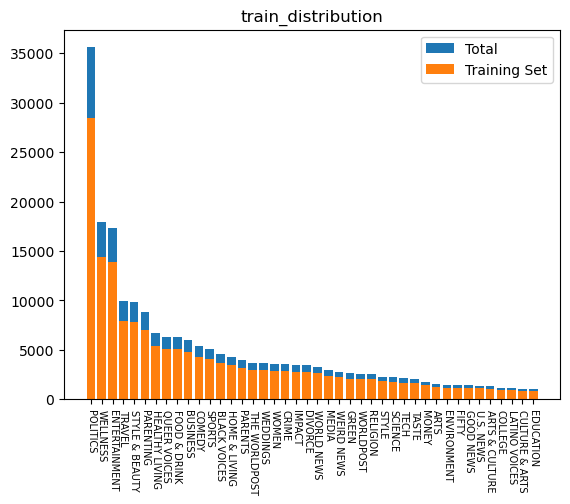

In [25]:
categories, train_distribution = zip(*sorted(list(zip(categories, train_distribution)),key=lambda x: x[1], reverse = True))
counts = df[['authors','category']].groupby('category').count().sort_values('authors',ascending =False).values[:,0]
plt.bar(categories, counts, label= 'Total')
plt.bar(categories, train_distribution, label= 'Training Set')
plt.title('train_distribution')
plt.xticks(rotation=270, size=7)
plt.legend()
plt.show()

In [26]:
display(df['category'].value_counts())
selected_cat=['POLITICS', 'ENTERTAINMENT', 'U.S. NEWS', 'WORLD NEWS']
data=df[['category','short_description']][df['category'].isin(selected_cat)].reset_index(drop=True)

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION       

In [27]:
# map label to int
class_names0=data['category'].unique().tolist()
class_names=sorted(class_names0)
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))
data['category']=data['category'].map(normal_mapping)

In [28]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
## clean_text

import string
from nltk.corpus import stopwords

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train['clean_text'] = train['short_description'].apply(clean_text)
test['clean_text'] = test['short_description'].apply(clean_text)

## remove_stopwords

stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    words = text.split(' ')
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    return text

train['clean_text'] = train['clean_text'].apply(remove_stopwords)
test['clean_text'] = test['clean_text'].apply(remove_stopwords)

##  stemm_text

import nltk

stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

train['clean_text'] = train['clean_text'].apply(stemm_text)
test['clean_text'] = test['clean_text'].apply(stemm_text)

## preprocess_data

def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

train['clean_text'] = train['clean_text'].apply(preprocess_data)
test['clean_text'] = test['clean_text'].apply(preprocess_data)

In [30]:
train['clean_text'] 

34931    atlantic city — the trump plaza casino and hot...
42887                      ron weasley gets a pilot at nbc
55600    this week nba commissioner adam silver brought...
49846                                                     
4707     rescue teams were still trying to reach some b...
                               ...                        
54343                                                     
38158    they are paying the price for their own extremism
860      the  screen actors guild awards will kick off ...
15795    the continuing campaign to exterminate the roh...
56422    stronger than me  back to black  love is a los...
Name: clean_text, Length: 46112, dtype: object

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer()
#fit_transform for train data
X_train = vectorizer.fit_transform(train['clean_text'])
y_train = train['category']
#transform for test data
X_test = vectorizer.transform(test['clean_text'])
y_test = test['category']

In [32]:
X_train

<46112x34869 sparse matrix of type '<class 'numpy.float64'>'
	with 614939 stored elements in Compressed Sparse Row format>

## Logistic Regression

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [34]:
model = LogisticRegression(random_state = 42)
model.fit(X_train, y_train)

C:\Users\Indra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [36]:
y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'acc:{acc}')

acc:0.7758863710289494


In [37]:
#Predictions on test set
test_pred = model.predict(X_test)
test_true= y_test

In [38]:
print(classification_report(test_true,test_pred,target_names=class_names,digits=4))

               precision    recall  f1-score   support

ENTERTAINMENT     0.8032    0.6078    0.6920      3417
     POLITICS     0.7667    0.9346    0.8423      7169
    U.S. NEWS     0.5238    0.0397    0.0738       277
   WORLD NEWS     0.7088    0.1940    0.3046       665

     accuracy                         0.7735     11528
    macro avg     0.7006    0.4440    0.4782     11528
 weighted avg     0.7683    0.7735    0.7483     11528

